### Outline:

Some EDA

Data Preprocessing: Column Transformer

Model Building: Pipeline

Model selection: Grid Search CV

Save model: Joblib

Make predictions on an unseen data point

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline    
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
%run app.py
import requests




 * Serving Flask app 'app'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

In [2]:
# print("Mark 1:", mark1)
# print("Mark 2:", mark2)

df = pd.read_csv('Mydata.csv')
df.head()

,id,first_name,last_name,email,Assignments,First Year Marks,Second Year Marks,Third Year Marks,Courses,Attendance,Country,Parantel Education
0,1,Belvia,Longstaffe,blongstaffe0@biblegateway.com,8,86,76,79,Support,93,United States,False
1,2,Thebault,Pavkovic,tpavkovic1@sciencedirect.com,9,95,96,93,Research and Development,90,Russia,False
2,3,Sherry,Tethacot,stethacot2@nbcnews.com,8,75,75,77,Product Management,91,Kazakhstan,True
3,4,Morissa,Lumby,mlumby3@ftc.gov,10,71,87,80,Sales,82,Russia,False
4,5,Cynthie,Dosdill,cdosdill4@macromedia.com,8,79,84,74,Product Management,89,United States,True


In [3]:
df.shape

(100, 12)

In [4]:
scores = df.columns[df.columns.str.contains('Marks')].tolist()
scores

['First Year Marks', 'Second Year Marks', 'Third Year Marks']

##### EDA:

histograms:

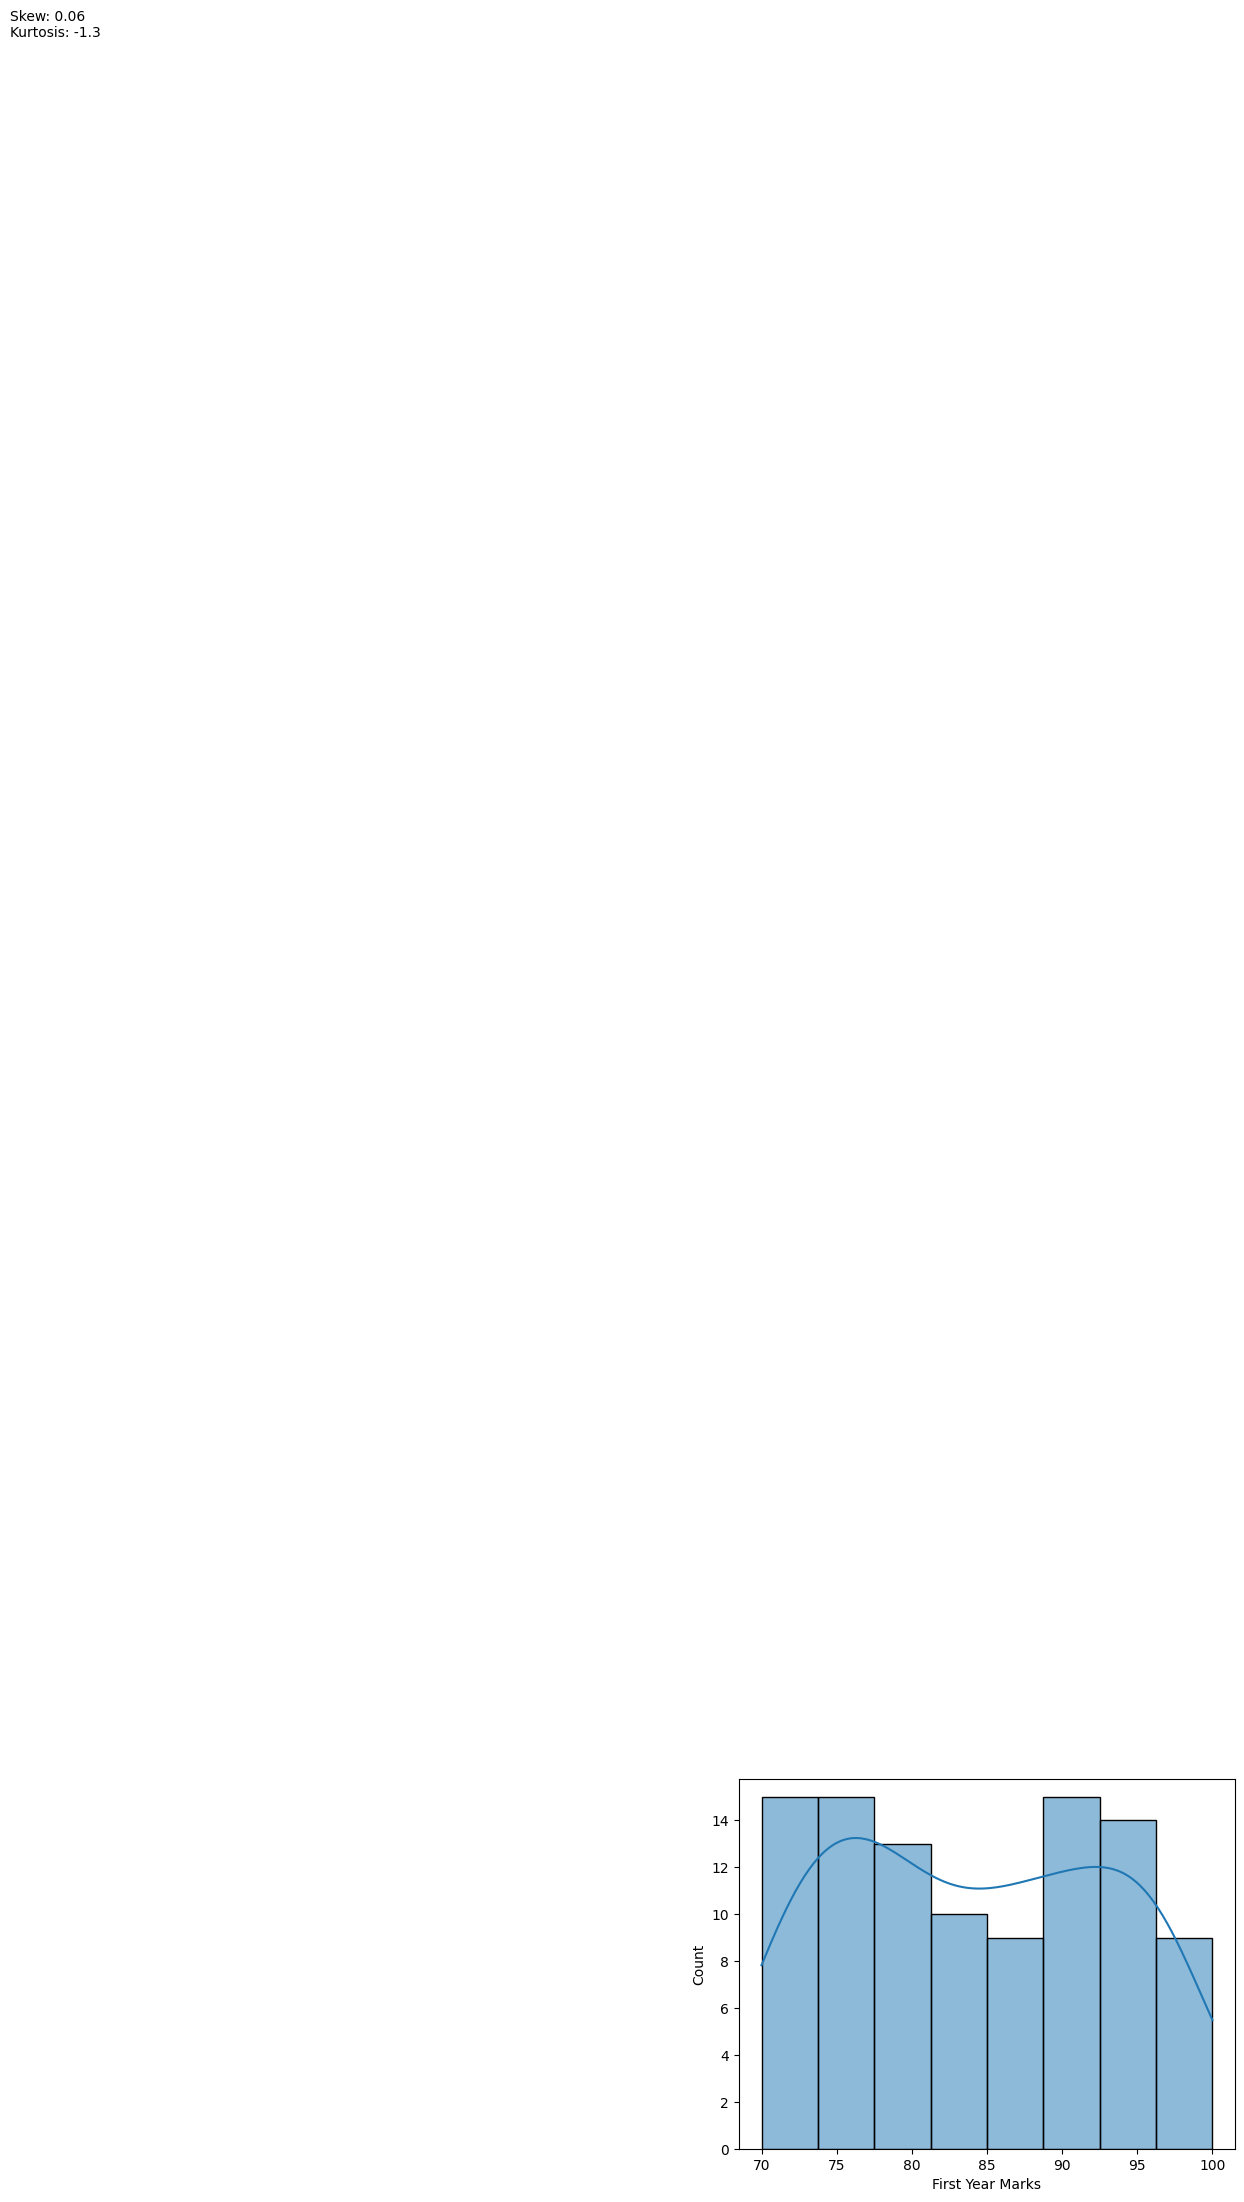

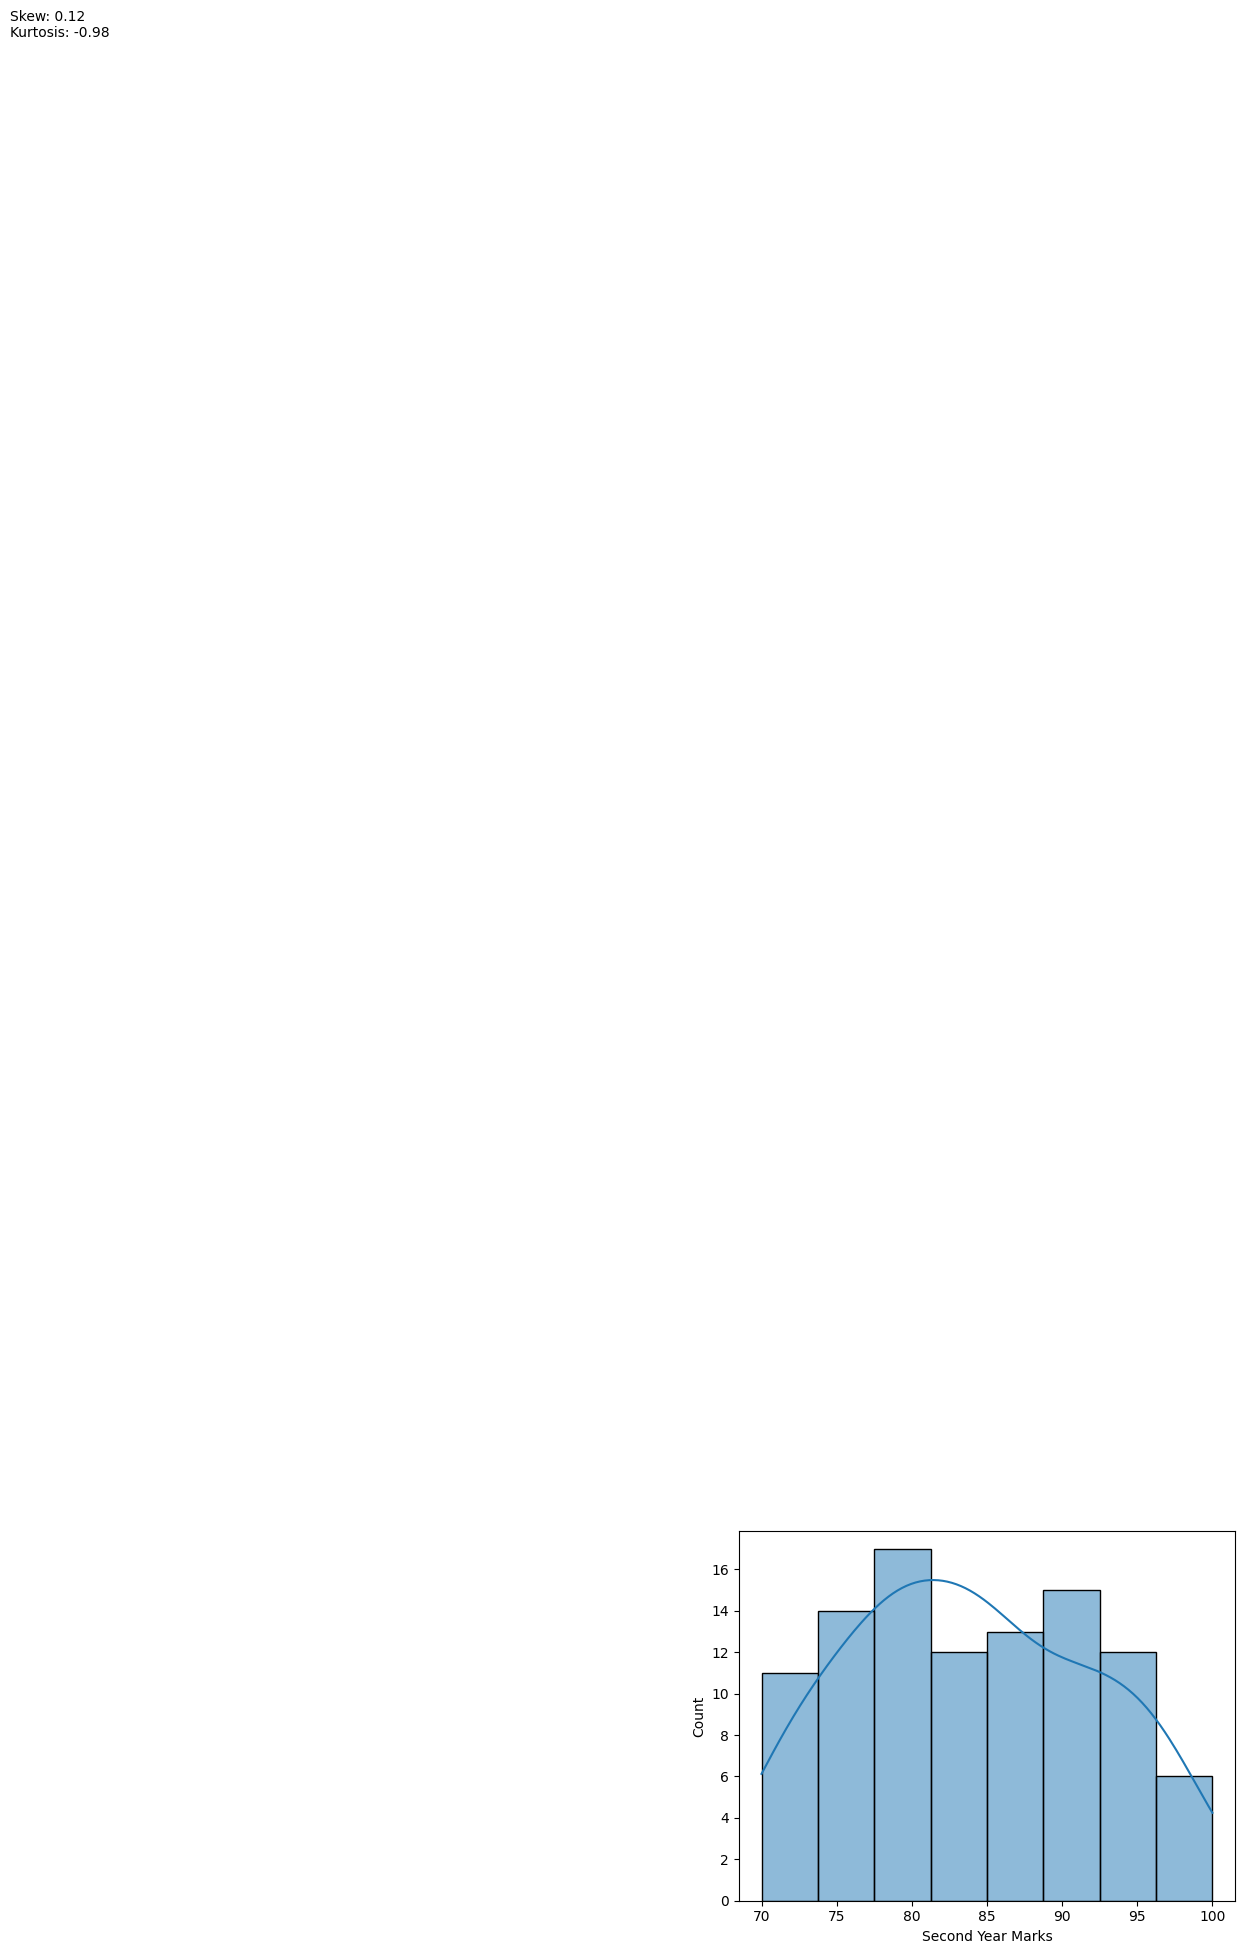

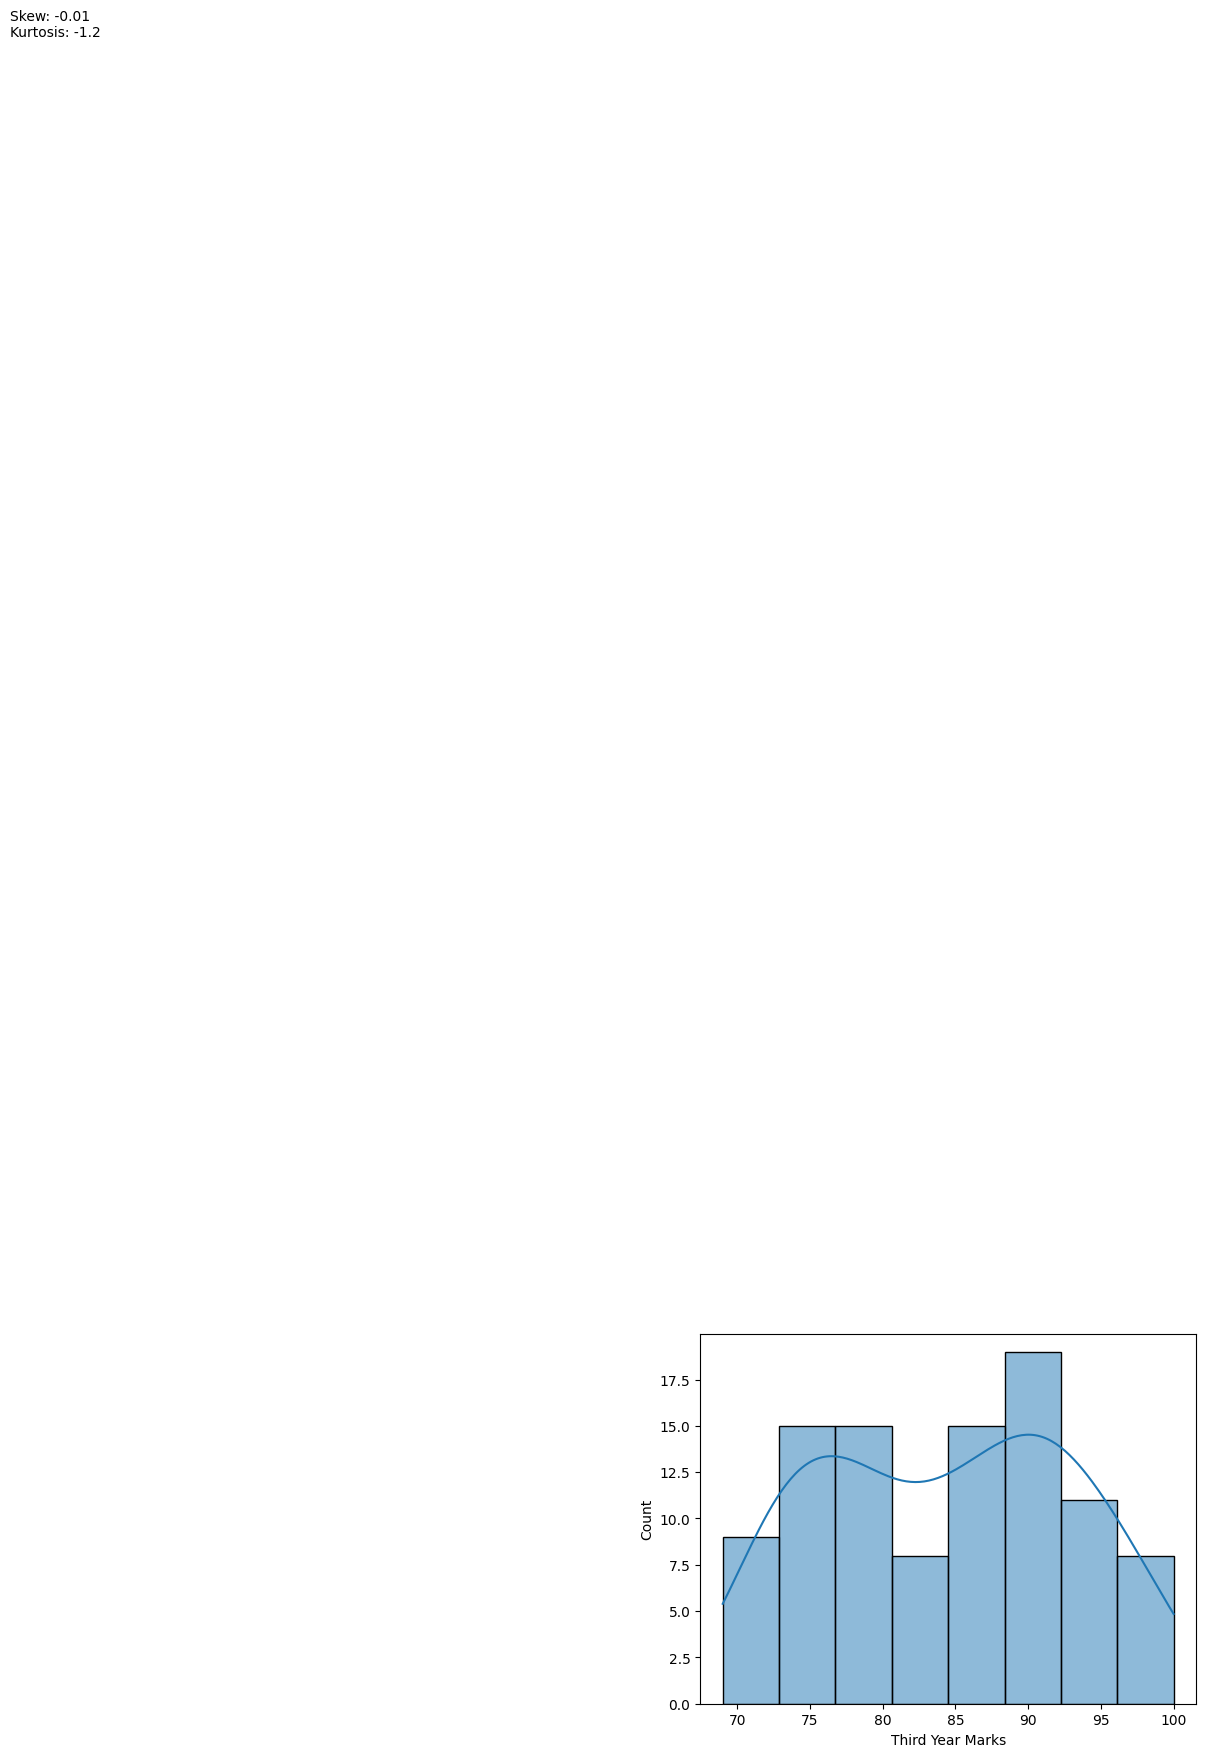

In [5]:
for Marks in scores:
    sns.histplot(df[Marks], element='bars', kde=True)
    plt.text(x=20, y=90, s=f"Skew: {round(df[Marks].skew(),2)}\nKurtosis: {round(df[Marks].kurt(),2)}")
    plt.show()

In [6]:
df.describe()

,id,Assignments,First Year Marks,Second Year Marks,Third Year Marks,Attendance
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,50.500000,8.270000,84.080000,83.98000,84.380000,89.960000
std,29.011492,1.043063,8.947298,8.10908,8.512356,5.877401
min,1.000000,7.000000,70.000000,70.00000,69.000000,80.000000
25%,25.750000,7.000000,76.000000,77.75000,77.000000,85.000000
50%,50.500000,8.000000,84.000000,84.00000,85.000000,90.000000
75%,75.250000,9.000000,92.000000,90.25000,92.000000,95.000000
max,100.000000,10.000000,100.000000,100.00000,100.000000,100.000000


pairplot:

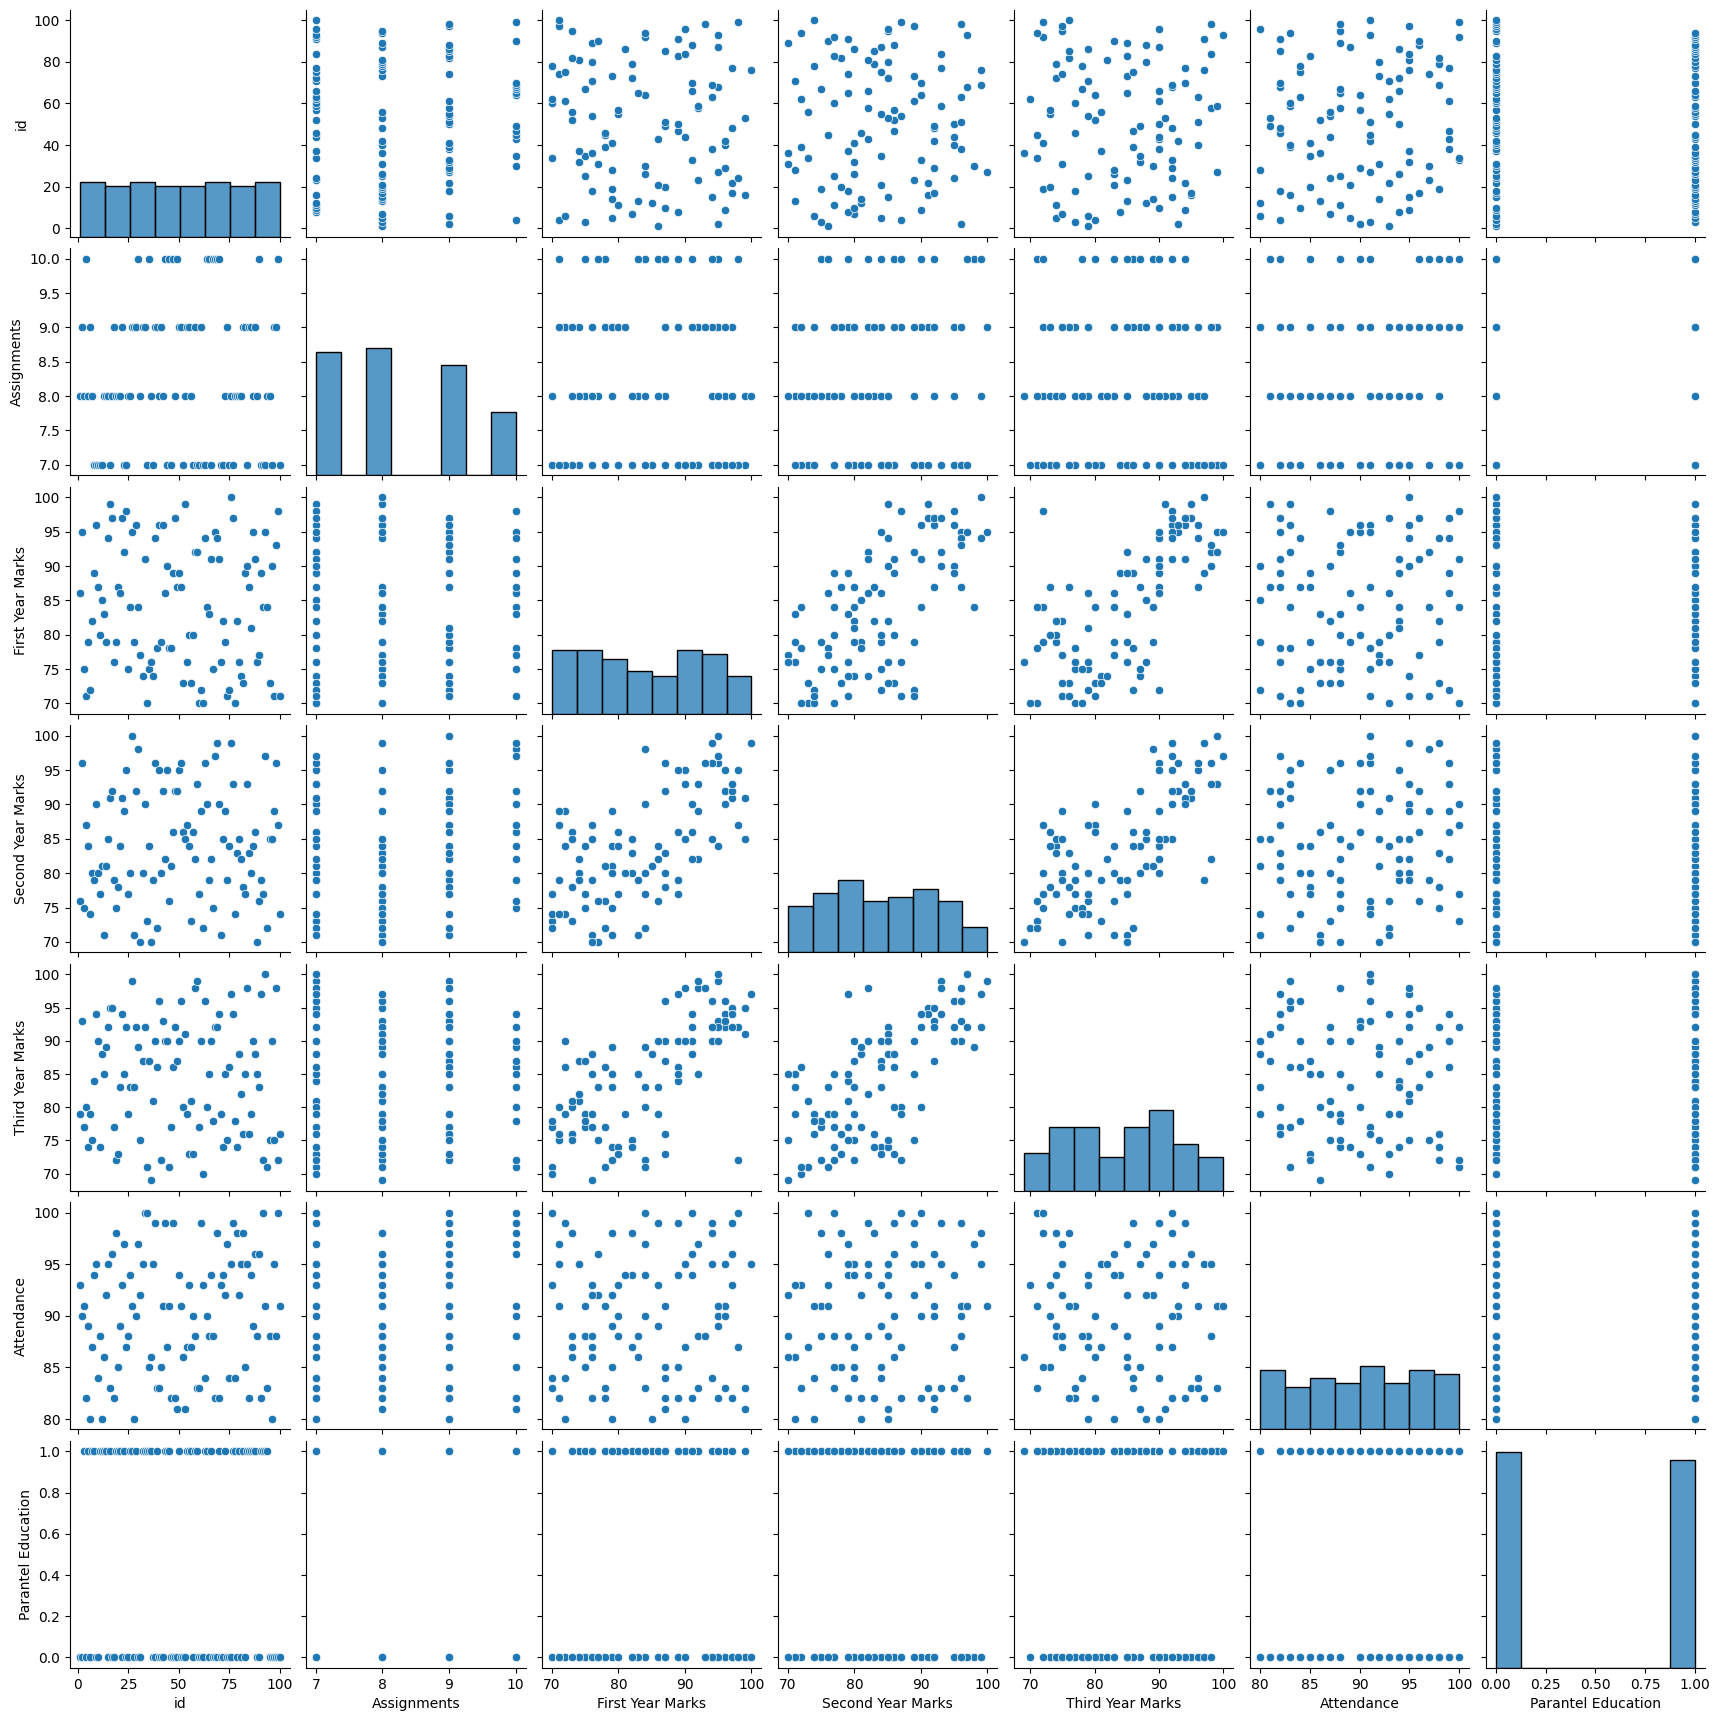

In [7]:
sns.pairplot(data=df)

scores vs lunch type:

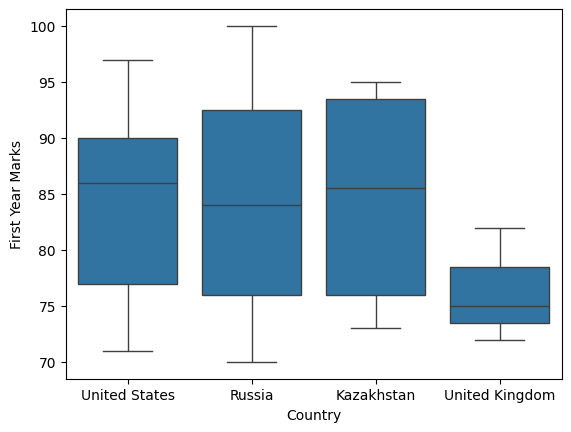

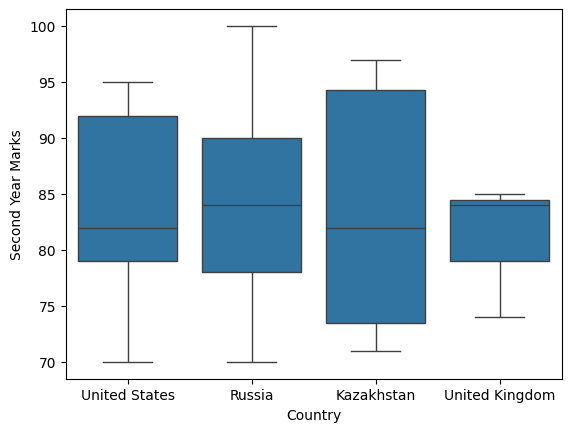

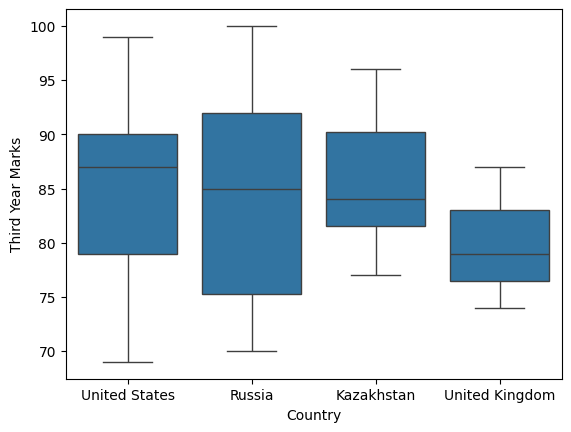

In [8]:
for score in scores:
    sns.boxplot(y=df[score], x=df['Country'])
    plt.show()

scores vs race/ ethnicity group:

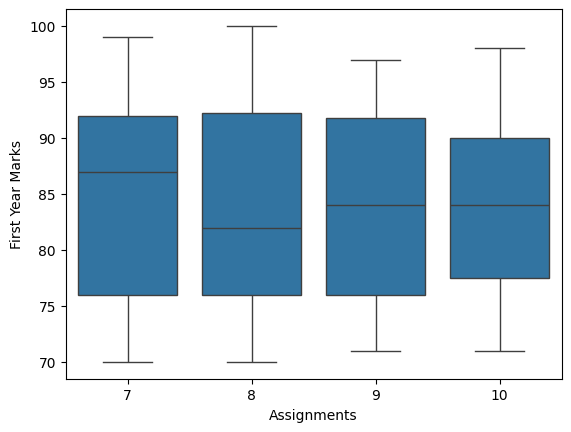

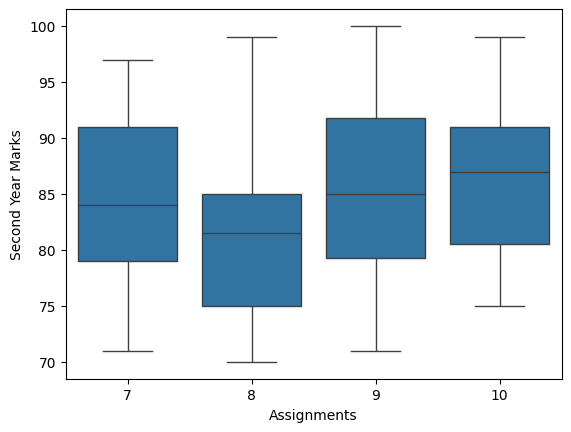

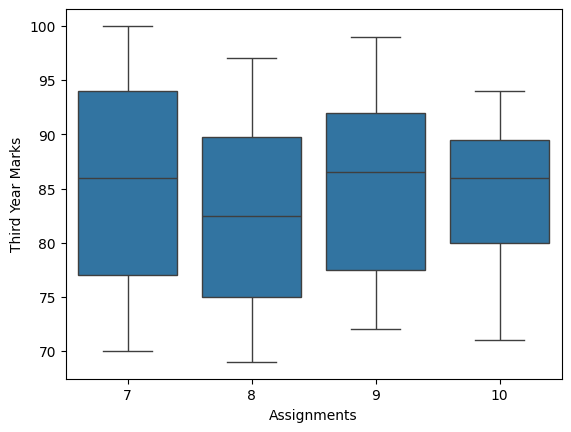

In [9]:
for score in scores:
    sns.boxplot(y=df[score], x=df['Assignments'])
    plt.show()

scores vs whether completed the test prep course:

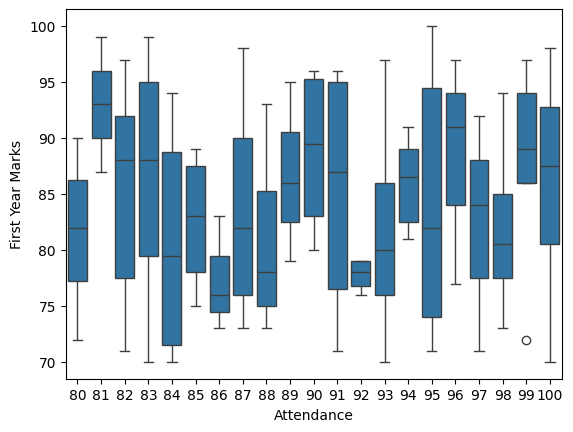

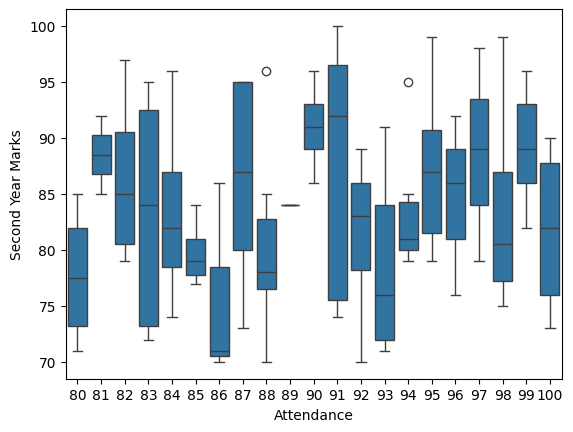

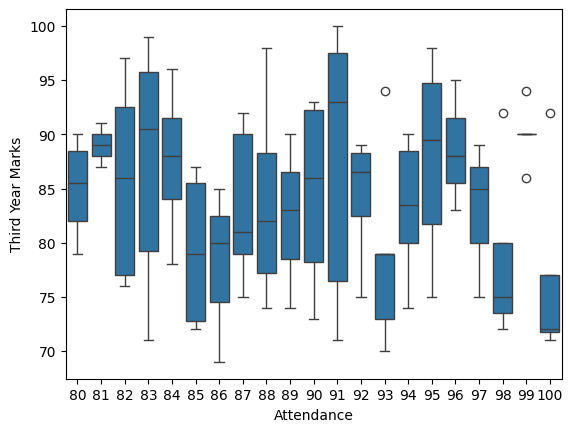

In [10]:
for score in scores:
    sns.boxplot(y=df[score], x=df['Attendance'])
    plt.show()

scores vs parental education level:

In [11]:
X, y = df.drop('Third Year Marks', axis=1), df['Third Year Marks']

In [12]:
cat_cols = X.dtypes[X.dtypes == 'O'].index.tolist()
cat_cols

['first_name', 'last_name', 'email', 'Courses', 'Country']

In [13]:
ct = ColumnTransformer([
    ('num', StandardScaler(), ['First Year Marks', 'Second Year Marks']),
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [14]:
ct.fit_transform(X).shape

(100, 322)

In [15]:
pipe = Pipeline([
    ('trf', ct),
    ('model', LGBMRegressor(random_state=0))
])

In [16]:
params = {
    'model__n_estimators':[100,130,150,170,190],
    'model__boosting_type': ['dart', 'gbdt', 'goss']
}

In [17]:
gs = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [18]:
gs.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 117
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 8
[LightGBM] [Info] Start training from score 84.380000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

GridSearchCV(estimator=Pipeline(steps=[('trf',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['First '
                                                                          'Year '
                                                                          'Marks',
                                                                          'Second '
                                                                          'Year '
                                                                          'Marks']),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['first_name',
                                                                          'last_name',
                                                                          'email',
                                                                          'Courses',
                                                                          'Country'])])),
                                       ('model',
                                        LGBMRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__boosting_type': ['dart', 'gbdt', 'goss'],
                         'model__n_estimators': [100, 130, 150, 170, 190]},
             scoring='neg_root_mean_squared_error')

In [19]:
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__boosting_type,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.244608,0.010600,0.014278,0.002371,gbdt,100,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.982689,-5.372132,-5.785457,-5.614077,-7.767256,-5.904322,0.969694,1
6,0.336068,0.041428,0.019943,0.002495,gbdt,130,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.907171,-5.405016,-5.877417,-5.622717,-7.786985,-5.919861,0.986596,2
7,0.394906,0.029365,0.017391,0.004510,gbdt,150,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.886922,-5.437861,-5.939276,-5.734293,-7.805308,-5.960732,0.987994,3
8,0.408184,0.040653,0.019880,0.004182,gbdt,170,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.862248,-5.447074,-6.054297,-5.782846,-7.822251,-5.993743,0.997067,4
9,0.547351,0.028585,0.020874,0.006316,gbdt,190,"{'model__boosting_type': 'gbdt', 'model__n_est...",-4.834915,-5.467259,-6.075902,-5.879669,-7.841874,-6.019924,1.005186,5
10,0.164122,0.012102,0.016282,0.006022,goss,100,"{'model__boosting_type': 'goss', 'model__n_est...",-5.666724,-5.193203,-6.398100,-5.347697,-7.751870,-6.071519,0.936958,6
11,0.368542,0.085126,0.027757,0.006900,goss,130,"{'model__boosting_type': 'goss', 'model__n_est...",-5.666724,-5.193203,-6.398100,-5.347697,-7.751870,-6.071519,0.936958,6
12,0.415218,0.049092,0.018165,0.006614,goss,150,"{'model__boosting_type': 'goss', 'model__n_est...",-5.666724,-5.193203,-6.398100,-5.347697,-7.751870,-6.071519,0.936958,6
13,0.447164,0.044330,0.024534,0.006770,goss,170,"{'model__boosting_type': 'goss', 'model__n_est...",-5.666724,-5.193203,-6.398100,-5.347697,-7.751870,-6.071519,0.936958,6
14,0.377300,0.080543,0.015704,0.001290,goss,190,"{'model__boosting_type': 'goss', 'model__n_est...",-5.666724,-5.193203,-6.398100,-5.347697,-7.751870,-6.071519,0.936958,6


In [20]:
gs.best_params_

{'model__boosting_type': 'gbdt', 'model__n_estimators': 100}

In [21]:
gs.best_score_

-5.904322347944476

In [22]:
gs.best_estimator_

Pipeline(steps=[('trf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['First Year Marks',
                                                   'Second Year Marks']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['first_name', 'last_name',
                                                   'email', 'Courses',
                                                   'Country'])])),
                ('model', LGBMRegressor(random_state=0))])

In [23]:
joblib.dump(gs.best_estimator_, 'model.joblib')

['model.joblib']

##### importing the model:

In [24]:
mdl = joblib.load('model.joblib')

##### Making predictions on a new data point NOT seen by the model

In [35]:

# m1 = "78"
# m2 = "90"


# q = pd.DataFrame([[3 , 'snagram' , 'patnaik' , 'sangramp@.net' , 'Male' , m1 , m2 , 'Engineering' , 'indian' , 'India' , True]],
#              columns=X.columns)
# q


import requests

# Define the Flask server URL
flask_url = 'http://localhost:5000'  # Replace with your Flask server URL if different

# Function to retrieve data from Flask
def retrieve_marks():
    try:
        response = requests.get(f'{flask_url}/get_marks')
        if response.status_code == 200:
            data = response.json()
            mark1 = data['mark1']
            mark2 = data['mark2']
            return mark1, mark2
        else:
            print("Failed to retrieve marks from Flask server")
            return None, None
    except Exception as e:
        print("An error occurred:", e)
        return None, None

# Retrieve marks from Flask
m1, m2 = retrieve_marks()

# Print the retrieved marks
print("Mark 1:", m1)
print("Mark 2:", m2)

q = pd.DataFrame([[3 , 'sangram' , 'patnaik' , 'sangramp@.net' , 7 , m1 , m2 , 'Engineering' , 90 , 'India' , True]],
              columns=X.columns)
q

Mark 1: 96
Mark 2: 95


,id,first_name,last_name,email,Assignments,First Year Marks,Second Year Marks,Courses,Attendance,Country,Parantel Education
0,3,sangram,patnaik,sangramp@.net,7,96,95,Engineering,90,India,True


In [36]:
m3 = mdl.predict(q)
m3 = int(m3)
# mdl.predict(q)
print(m3)

95


C:\Users\piyus\AppData\Local\Temp\ipykernel_16008\1623157616.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  m3 = int(m3)


In [38]:
m1 = int(m1)
m2 = int(m2)
avg1 = (m1 + m2 + m3) / 3
if 90 < avg1 < 100:
    print('''    The performance is good and he have to focus on their placement prepration. 
    In the prepration he have to focus on DSA concept
    and do the practice of interview as much as possible. Thank you ''')
elif 80 < avg1 <90:
    print('''   The performance comes under good condition but he have to focus more on their studies and he have to 
    start doing the questions of DSA because he dont have much time to waste. Thank you ''')
else:
    print('''   The performance is not good in their regular studies of colledge.
    First he have to focus on their normal stdies because according to the company their marks are lower then their criteria.
    Thank you ''')

# print(type(m1))

    The performance is good and he have to focus on their placement prepration. 
    In the prepration he have to focus on DSA concept
    and do the practice of interview as much as possible. Thank you 
